In [68]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
!pip install dagshub --upgrade

In [70]:
!pip install -q pandas numpy scikit-learn xgboost mlflow joblib kaggle

**Import neccessary libraries**

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import os
import zipfile
import mlflow
import mlflow.xgboost
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")
np.random.seed(42)

In [72]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [73]:
mlflow.set_tracking_uri("mlruns")
mlflow.set_experiment("walmart_sales_forecasting")

<Experiment: artifact_location='/content/mlruns/678949468289484664', creation_time=1753893432960, experiment_id='678949468289484664', last_update_time=1753893432960, lifecycle_stage='active', name='walmart_sales_forecasting', tags={}>

In [74]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [75]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

walmart-recruiting-store-sales-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)


In [76]:
!mkdir -p data
!unzip walmart-recruiting-store-sales-forecasting.zip -d data/

Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: data/features.csv.zip   
  inflating: data/sampleSubmission.csv.zip  
replace data/stores.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/stores.csv         
  inflating: data/test.csv.zip       
  inflating: data/train.csv.zip      


**Data** **visualisation**

In [77]:
import os
print(os.listdir("data"))

['sampleSubmission.csv', 'stores.csv', 'train.csv.zip', 'features.csv.zip', 'test.csv.zip', 'test.csv', 'train.csv', 'features.csv', 'sampleSubmission.csv.zip']


In [78]:
import os
import zipfile

data_dir = "data"
for file in os.listdir(data_dir):
    if file.endswith(".zip"):
        file_path = os.path.join(data_dir, file)
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print(f"Unzipped {file}")

print("Updated contents of data directory:", os.listdir(data_dir))

Unzipped train.csv.zip
Unzipped features.csv.zip
Unzipped test.csv.zip
Unzipped sampleSubmission.csv.zip
Updated contents of data directory: ['sampleSubmission.csv', 'stores.csv', 'train.csv.zip', 'features.csv.zip', 'test.csv.zip', 'test.csv', 'train.csv', 'features.csv', 'sampleSubmission.csv.zip']


In [79]:
!rm data/*.zip
print("Remaining files:", os.listdir("data"))

Remaining files: ['sampleSubmission.csv', 'stores.csv', 'test.csv', 'train.csv', 'features.csv']


In [80]:
train = pd.read_csv("data/train.csv")
stores = pd.read_csv("data/stores.csv")
features = pd.read_csv("data/features.csv")
test = pd.read_csv("data/test.csv")

print("Train shape:", train.shape)
print("Stores shape:", stores.shape)
print("Features shape:", features.shape)
print("Test shape:", test.shape)


Train shape: (421570, 5)
Stores shape: (45, 3)
Features shape: (8190, 12)
Test shape: (115064, 4)


In [81]:
train_full = train.merge(stores, on='Store').merge(features, on=['Store', 'Date'])
test_full = test.merge(stores, on='Store').merge(features, on=['Store', 'Date'])

print("Train: ", train_full.shape)
print("Test: ", test_full.shape)

Train:  (421570, 17)
Test:  (115064, 16)


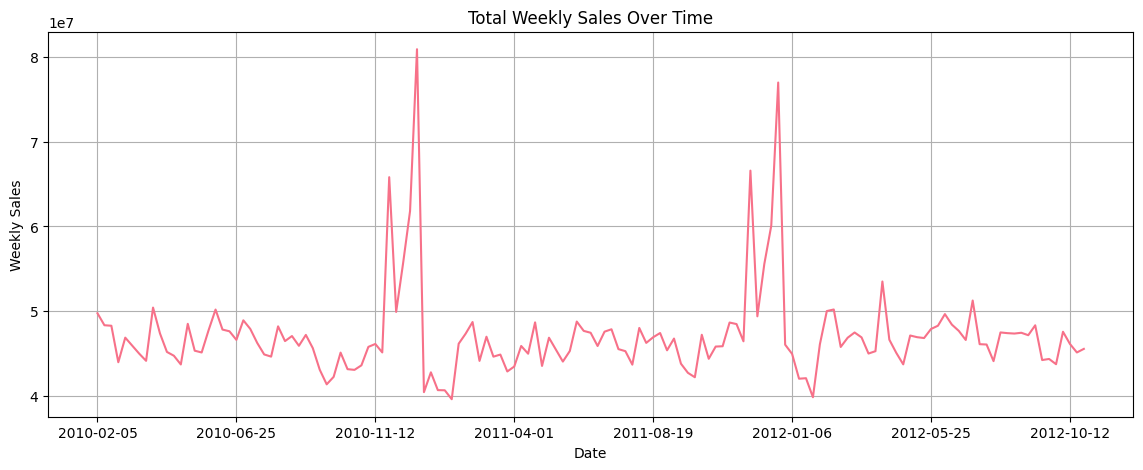

In [82]:
plt.figure(figsize=(14, 5))
train_full.groupby('Date')['Weekly_Sales'].sum().plot()
plt.title('Total Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

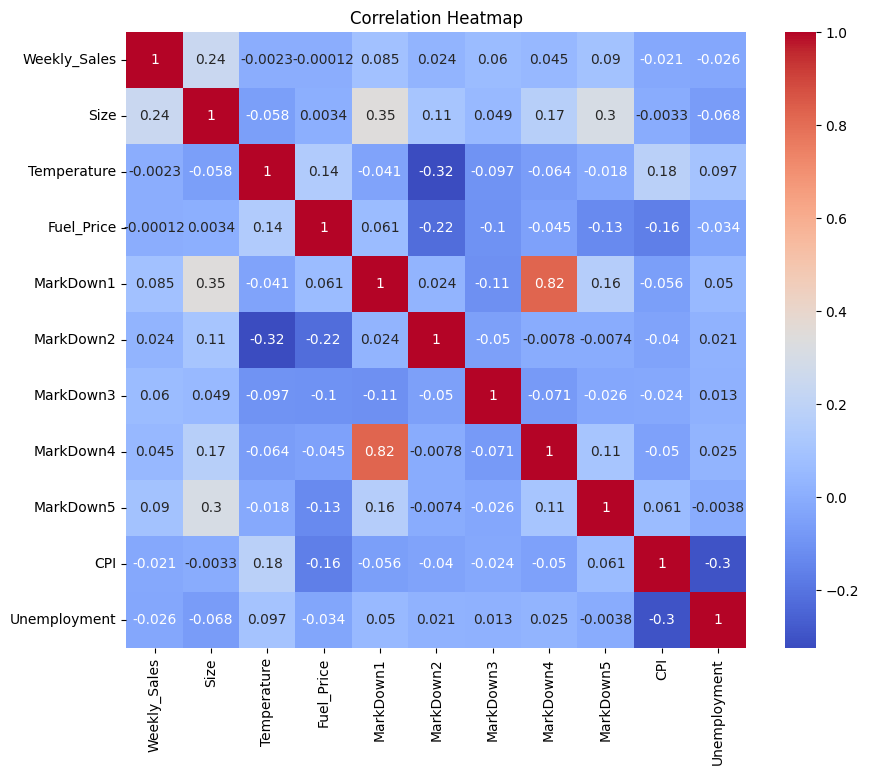

In [83]:
numeric_cols = train_full.select_dtypes(include=['float64', 'int64']).drop(columns=['Store', 'Dept']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_cols, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

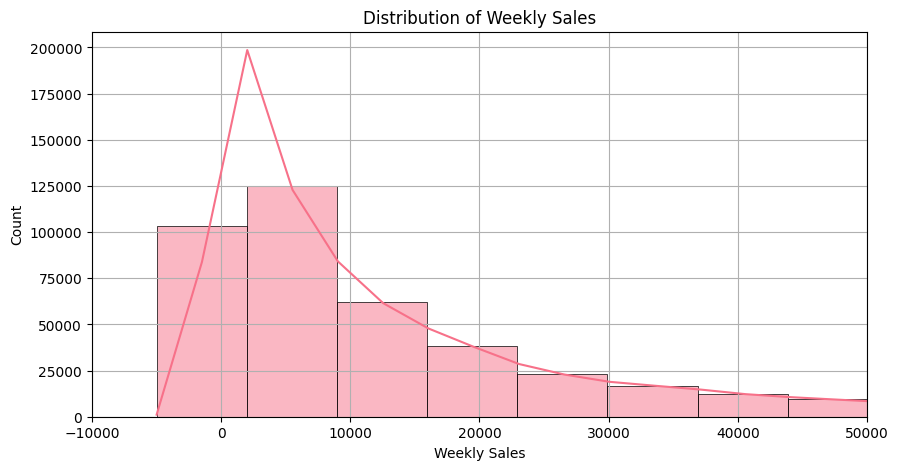

In [84]:
plt.figure(figsize=(10, 5))
sns.histplot(train_full['Weekly_Sales'], bins=100, kde=True)
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.xlim(-10000, 50000)
plt.grid(True)
plt.show()

In [85]:
print(train_full)
print('-----------Test Data------------')
print(test_full)

        Store  Dept        Date  Weekly_Sales  IsHoliday_x Type    Size  \
0           1     1  2010-02-05      24924.50        False    A  151315   
1           1     1  2010-02-12      46039.49         True    A  151315   
2           1     1  2010-02-19      41595.55        False    A  151315   
3           1     1  2010-02-26      19403.54        False    A  151315   
4           1     1  2010-03-05      21827.90        False    A  151315   
...       ...   ...         ...           ...          ...  ...     ...   
421565     45    98  2012-09-28        508.37        False    B  118221   
421566     45    98  2012-10-05        628.10        False    B  118221   
421567     45    98  2012-10-12       1061.02        False    B  118221   
421568     45    98  2012-10-19        760.01        False    B  118221   
421569     45    98  2012-10-26       1076.80        False    B  118221   

        Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0             42.31 

In [86]:
print("Data type of Type:", train_full['Type'].dtype)

Data type of Type: object


**Data Cleaning**

In [87]:
train_full.isnull().mean().sort_values(ascending=False)

,0
MarkDown2,0.736110
MarkDown4,0.679847
MarkDown3,0.674808
MarkDown1,0.642572
MarkDown5,0.640790
Store,0.000000
Dept,0.000000
Weekly_Sales,0.000000
Date,0.000000
Fuel_Price,0.000000


In [88]:
test_full.isnull().mean().sort_values(ascending=False)

,0
CPI,0.331659
Unemployment,0.331659
MarkDown2,0.248792
MarkDown4,0.112007
MarkDown3,0.085422
MarkDown1,0.001295
Store,0.000000
Dept,0.000000
Fuel_Price,0.000000
Temperature,0.000000


In [89]:
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
train_full[markdown_cols] = train_full[markdown_cols].fillna(0)
test_full[markdown_cols] = test_full[markdown_cols].fillna(0)
print(train_full)
print(test_full)

        Store  Dept        Date  Weekly_Sales  IsHoliday_x Type    Size  \
0           1     1  2010-02-05      24924.50        False    A  151315   
1           1     1  2010-02-12      46039.49         True    A  151315   
2           1     1  2010-02-19      41595.55        False    A  151315   
3           1     1  2010-02-26      19403.54        False    A  151315   
4           1     1  2010-03-05      21827.90        False    A  151315   
...       ...   ...         ...           ...          ...  ...     ...   
421565     45    98  2012-09-28        508.37        False    B  118221   
421566     45    98  2012-10-05        628.10        False    B  118221   
421567     45    98  2012-10-12       1061.02        False    B  118221   
421568     45    98  2012-10-19        760.01        False    B  118221   
421569     45    98  2012-10-26       1076.80        False    B  118221   

        Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
0             42.31 

In [90]:
if train_full['IsHoliday_x'].equals(train_full['IsHoliday_y']):
    train_full['IsHoliday'] = train_full['IsHoliday_x']

train_full = train_full.drop(columns=['IsHoliday_y'], errors='ignore')
train_full = train_full.drop(columns=['IsHoliday_x'], errors='ignore')

if test_full['IsHoliday_x'].equals(test_full['IsHoliday_y']):
    test_full['IsHoliday'] = test_full['IsHoliday_x']

test_full = test_full.drop(columns=['IsHoliday_y'], errors='ignore')
test_full = test_full.drop(columns=['IsHoliday_x'], errors='ignore')

In [91]:
train_full['CPI'] = train_full['CPI'].fillna(train_full['CPI'].median())
train_full['Unemployment'] = train_full['Unemployment'].fillna(train_full['Unemployment'].median())
train_full['IsHoliday'] = train_full['IsHoliday'].astype(int)
print(train_full)

print("=" * 100)

test_full['CPI'] = test_full['CPI'].fillna(test_full['CPI'].median())
test_full['Unemployment'] = test_full['Unemployment'].fillna(test_full['Unemployment'].median())
test_full['IsHoliday'] = test_full['IsHoliday'].astype(int)
print(test_full)

        Store  Dept        Date  Weekly_Sales Type    Size  Temperature  \
0           1     1  2010-02-05      24924.50    A  151315        42.31   
1           1     1  2010-02-12      46039.49    A  151315        38.51   
2           1     1  2010-02-19      41595.55    A  151315        39.93   
3           1     1  2010-02-26      19403.54    A  151315        46.63   
4           1     1  2010-03-05      21827.90    A  151315        46.50   
...       ...   ...         ...           ...  ...     ...          ...   
421565     45    98  2012-09-28        508.37    B  118221        64.88   
421566     45    98  2012-10-05        628.10    B  118221        64.89   
421567     45    98  2012-10-12       1061.02    B  118221        54.47   
421568     45    98  2012-10-19        760.01    B  118221        56.47   
421569     45    98  2012-10-26       1076.80    B  118221        58.85   

        Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5  \
0            2.572    

In [92]:
if 'Weekly_Sales' in train_full.columns:
    train_full = train_full[train_full['Weekly_Sales'] >= 0]
    Q1 = train_full['Weekly_Sales'].quantile(0.25)
    Q3 = train_full['Weekly_Sales'].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 2.5 * IQR

    train_full['Date'] = pd.to_datetime(train_full['Date'])
    holiday_mask = (train_full['IsHoliday'] == 1) | (train_full['Date'].dt.month.isin([11, 12]))
    outlier_mask = train_full['Weekly_Sales'] > upper_bound

    outliers_to_cap = (~holiday_mask & outlier_mask).sum()
    train_full.loc[~holiday_mask & outlier_mask, 'Weekly_Sales'] = upper_bound

In [93]:
train_full['Type'] = train_full['Type'].astype('category')
train_full['Type']

,Type
0,A
1,A
2,A
3,A
4,A
...,...
421565,B
421566,B
421567,B
421568,B


In [94]:
test_full['IsHoliday'] = test_full['IsHoliday'].astype(int)
test_full['Type'] = test_full['Type'].astype('category')

In [95]:
print(f"Final training shape: {train_full.shape}")
print(f"Final test shape: {test_full.shape}")

Final training shape: (420285, 16)
Final test shape: (115064, 15)


In [96]:
remaining_missing_train = train_full.isnull().sum()
print(remaining_missing_train[remaining_missing_train > 0])
remaining_missing_test = test_full.isnull().sum()
print(remaining_missing_test[remaining_missing_test > 0])

Series([], dtype: int64)
Series([], dtype: int64)


**Feature Engineering**

In [97]:
train_full['Date'] = pd.to_datetime(train_full['Date'])
test_full['Date'] = pd.to_datetime(test_full['Date'])

In [98]:
train_full['Year'] = train_full['Date'].dt.year
train_full['Month'] = train_full['Date'].dt.month
train_full['DayOfWeek'] = train_full['Date'].dt.dayofweek
train_full['Quarter'] = train_full['Date'].dt.quarter
train_full['WeekOfYear'] = train_full['Date'].dt.isocalendar().week
train_full['IsMonthEnd'] = train_full['Date'].dt.is_month_end.astype(int)
train_full['IsMonthStart'] = train_full['Date'].dt.is_month_start.astype(int)
train_full['DayOfMonth'] = train_full['Date'].dt.day

print(train_full)

        Store  Dept       Date  Weekly_Sales Type    Size  Temperature  \
0           1     1 2010-02-05      24924.50    A  151315        42.31   
1           1     1 2010-02-12      46039.49    A  151315        38.51   
2           1     1 2010-02-19      41595.55    A  151315        39.93   
3           1     1 2010-02-26      19403.54    A  151315        46.63   
4           1     1 2010-03-05      21827.90    A  151315        46.50   
...       ...   ...        ...           ...  ...     ...          ...   
421565     45    98 2012-09-28        508.37    B  118221        64.88   
421566     45    98 2012-10-05        628.10    B  118221        64.89   
421567     45    98 2012-10-12       1061.02    B  118221        54.47   
421568     45    98 2012-10-19        760.01    B  118221        56.47   
421569     45    98 2012-10-26       1076.80    B  118221        58.85   

        Fuel_Price  MarkDown1  MarkDown2  ...  Unemployment  IsHoliday  Year  \
0            2.572       0.00  

In [99]:
test_full['Year'] = test_full['Date'].dt.year
test_full['Month'] = test_full['Date'].dt.month
test_full['DayOfWeek'] = test_full['Date'].dt.dayofweek
test_full['Quarter'] = test_full['Date'].dt.quarter
test_full['WeekOfYear'] = test_full['Date'].dt.isocalendar().week
test_full['IsMonthEnd'] = test_full['Date'].dt.is_month_end.astype(int)
test_full['IsMonthStart'] = test_full['Date'].dt.is_month_start.astype(int)
test_full['DayOfMonth'] = test_full['Date'].dt.day

print(test_full)

        Store  Dept       Date Type    Size  Temperature  Fuel_Price  \
0           1     1 2012-11-02    A  151315        55.32       3.386   
1           1     1 2012-11-09    A  151315        61.24       3.314   
2           1     1 2012-11-16    A  151315        52.92       3.252   
3           1     1 2012-11-23    A  151315        56.23       3.211   
4           1     1 2012-11-30    A  151315        52.34       3.207   
...       ...   ...        ...  ...     ...          ...         ...   
115059     45    98 2013-06-28    B  118221        76.05       3.639   
115060     45    98 2013-07-05    B  118221        77.50       3.614   
115061     45    98 2013-07-12    B  118221        79.37       3.614   
115062     45    98 2013-07-19    B  118221        82.84       3.737   
115063     45    98 2013-07-26    B  118221        76.06       3.804   

        MarkDown1  MarkDown2  MarkDown3  ...  Unemployment  IsHoliday  Year  \
0         6766.44    5147.70      50.82  ...         6.5

In [100]:
train_full['Season'] = train_full['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

train_full['HolidaySeason'] = train_full['Month'].isin([10, 11, 12, 1]).astype(int)
train_full['BackToSchool'] = train_full['Month'].isin([8, 9]).astype(int)

In [101]:
test_full['Season'] = test_full['Month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

test_full['HolidaySeason'] = test_full['Month'].isin([10, 11, 12, 1]).astype(int)
test_full['BackToSchool'] = test_full['Month'].isin([8, 9]).astype(int)

In [102]:
store_stats = train_full.groupby('Store')['Weekly_Sales'].agg(['mean', 'std', 'median']).reset_index()
store_stats.columns = ['Store', 'Store_Sales_Mean', 'Store_Sales_Std', 'Store_Sales_Median']
train_full = train_full.merge(store_stats, on='Store', how='left')
test_full = test_full.merge(store_stats, on='Store', how='left')

In [103]:
dept_stats = train_full.groupby('Dept')['Weekly_Sales'].agg(['mean', 'std', 'median']).reset_index()
dept_stats.columns = ['Dept', 'Dept_Sales_Mean', 'Dept_Sales_Std', 'Dept_Sales_Median']
train_full = train_full.merge(dept_stats, on='Dept', how='left')
test_full = test_full.merge(dept_stats, on='Dept', how='left')

In [104]:
train_full['Type_Size_Interaction'] = train_full['Type'].astype(str) + '_' + pd.cut(
    train_full['Size'], bins=3, labels=['Small', 'Medium', 'Large']).astype(str)

train_full['Holiday_Type_Interaction'] = train_full['IsHoliday'].astype(str) + '_' + train_full['Type'].astype(str)
train_full['Temp_Category'] = pd.cut(train_full['Temperature'], bins=4, labels=['Cold', 'Cool', 'Warm', 'Hot'])

In [105]:
test_full['Type_Size_Interaction'] = test_full['Type'].astype(str) + '_' + pd.cut(
    test_full['Size'], bins=3, labels=['Small', 'Medium', 'Large']).astype(str)

test_full['Holiday_Type_Interaction'] = test_full['IsHoliday'].astype(str) + '_' + test_full['Type'].astype(str)

test_full['Temp_Category'] = pd.cut(test_full['Temperature'], bins=4, labels=['Cold', 'Cool', 'Warm', 'Hot'])

In [106]:
train_full = train_full.sort_values(['Store', 'Dept', 'Date'])
test_full = test_full.sort_values(['Store', 'Dept', 'Date'])

train_full['Weekly_Sales_Lag1'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
train_full['Weekly_Sales_Lag4'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)
train_full['Weekly_Sales_Lag52'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)
train_full['Weekly_Sales_Roll4_Mean'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(4, min_periods=1).mean())
train_full['Weekly_Sales_Roll12_Mean'] = train_full.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(lambda x: x.rolling(12, min_periods=1).mean())
new_cols = [col for col in train_full.columns if col not in ['Store', 'Dept', 'Date', 'Weekly_Sales', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday']]

In [107]:
print(train_full)

        Store  Dept       Date  Weekly_Sales Type    Size  Temperature  \
0           1     1 2010-02-05      24924.50    A  151315        42.31   
1           1     1 2010-02-12      46039.49    A  151315        38.51   
2           1     1 2010-02-19      41595.55    A  151315        39.93   
3           1     1 2010-02-26      19403.54    A  151315        46.63   
4           1     1 2010-03-05      21827.90    A  151315        46.50   
...       ...   ...        ...           ...  ...     ...          ...   
420280     45    98 2012-09-28        508.37    B  118221        64.88   
420281     45    98 2012-10-05        628.10    B  118221        64.89   
420282     45    98 2012-10-12       1061.02    B  118221        54.47   
420283     45    98 2012-10-19        760.01    B  118221        56.47   
420284     45    98 2012-10-26       1076.80    B  118221        58.85   

        Fuel_Price  MarkDown1  MarkDown2  ...  Dept_Sales_Std  \
0            2.572       0.00       0.00  ... 

In [108]:
print(test_full)

        Store  Dept       Date Type    Size  Temperature  Fuel_Price  \
0           1     1 2012-11-02    A  151315        55.32       3.386   
1           1     1 2012-11-09    A  151315        61.24       3.314   
2           1     1 2012-11-16    A  151315        52.92       3.252   
3           1     1 2012-11-23    A  151315        56.23       3.211   
4           1     1 2012-11-30    A  151315        52.34       3.207   
...       ...   ...        ...  ...     ...          ...         ...   
115059     45    98 2013-06-28    B  118221        76.05       3.639   
115060     45    98 2013-07-05    B  118221        77.50       3.614   
115061     45    98 2013-07-12    B  118221        79.37       3.614   
115062     45    98 2013-07-19    B  118221        82.84       3.737   
115063     45    98 2013-07-26    B  118221        76.06       3.804   

        MarkDown1  MarkDown2  MarkDown3  ...  BackToSchool  Store_Sales_Mean  \
0         6766.44    5147.70      50.82  ...           

**Data Analysis**

In [109]:
plt.style.use('default')
sns.set_palette("husl")

Text(0, 0.5, 'Frequency')

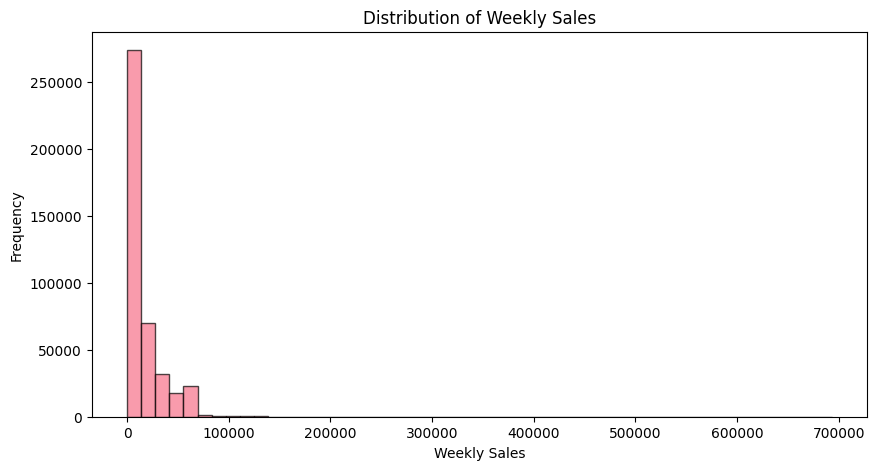

In [110]:
plt.figure(figsize=(10, 5))
plt.hist(train_full['Weekly_Sales'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')

Text(0.5, 0.98, '')

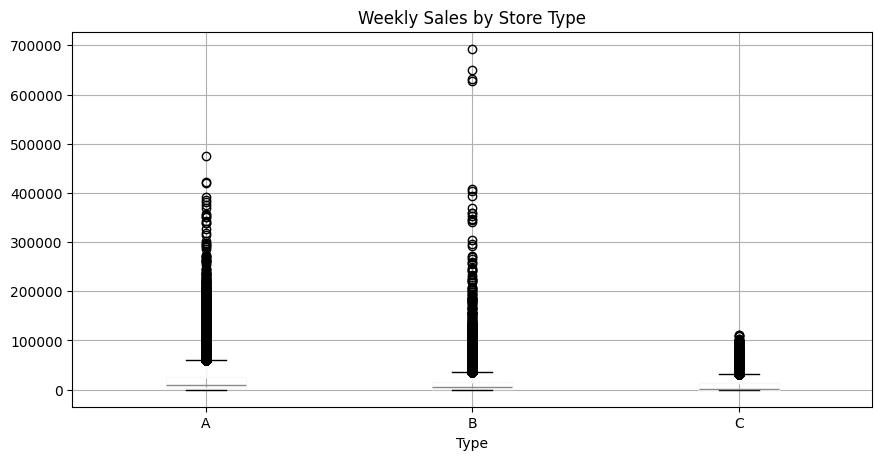

In [111]:
plt.figure(figsize=(10, 5))
train_full.boxplot(column='Weekly_Sales', by='Type', ax=plt.gca())
plt.title('Weekly Sales by Store Type')
plt.suptitle('')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

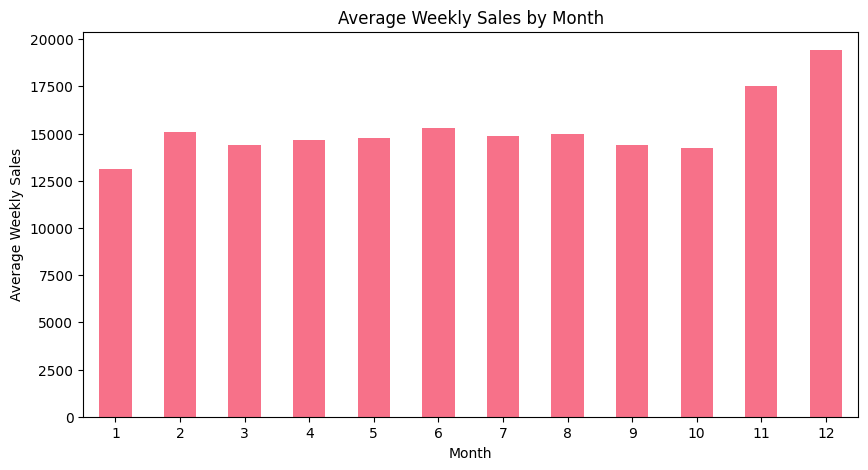

In [112]:
plt.figure(figsize=(10, 5))
monthly_sales = train_full.groupby('Month')['Weekly_Sales'].mean()
monthly_sales.plot(kind='bar')
plt.title('Average Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)

(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

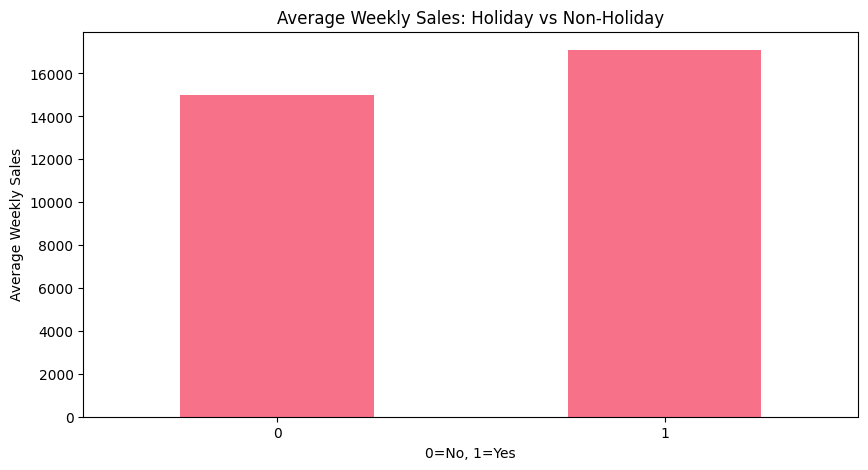

In [113]:
plt.figure(figsize=(10, 5))
holiday_sales = train_full.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_sales.plot(kind='bar')
plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
plt.xlabel('0=No, 1=Yes')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)

(array([0]), [Text(0, 0, '4')])

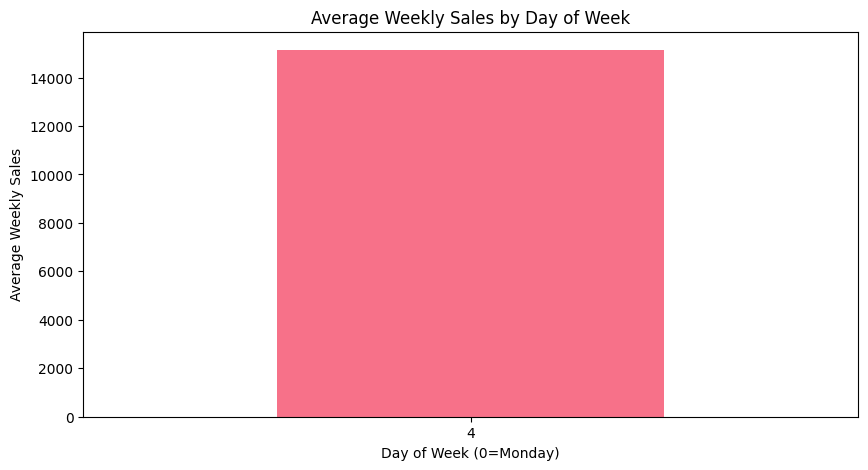

In [114]:
plt.figure(figsize=(10, 5))
train_full.groupby('DayOfWeek')['Weekly_Sales'].mean().plot(kind='bar')
plt.title('Average Weekly Sales by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Fall'),
  Text(1, 0, 'Spring'),
  Text(2, 0, 'Summer'),
  Text(3, 0, 'Winter')])

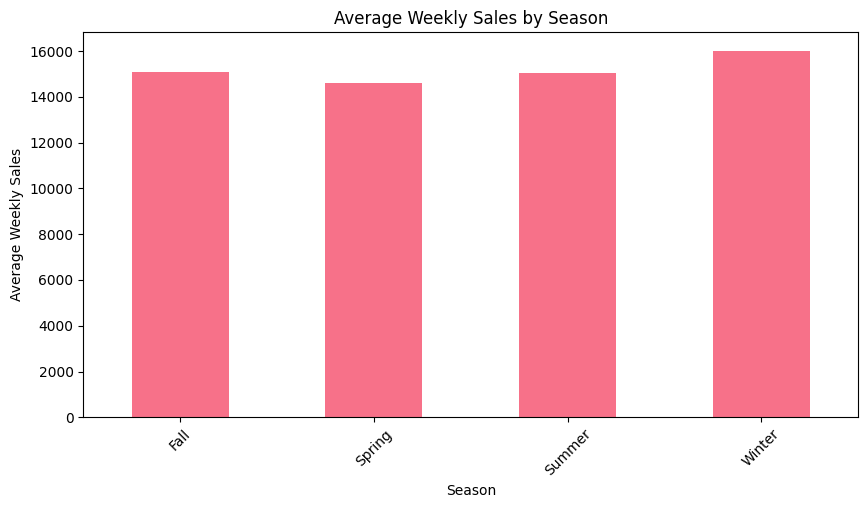

In [115]:
plt.figure(figsize=(10, 5))
seasonal_sales = train_full.groupby('Season')['Weekly_Sales'].mean()
seasonal_sales.plot(kind='bar')
plt.title('Average Weekly Sales by Season')
plt.xlabel('Season')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=45)


**Feature Selection**

In [116]:
features_to_drop = [
    'Date',
    'Weekly_Sales',
    'Weekly_Sales_Lag1', 'Weekly_Sales_Lag4', 'Weekly_Sales_Lag52',
    'Weekly_Sales_Roll4_Mean', 'Weekly_Sales_Roll12_Mean'
]

In [117]:
feature_cols = [col for col in train_full.columns if col not in features_to_drop]
print(feature_cols)

['Store', 'Dept', 'Type', 'Size', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'DayOfWeek', 'Quarter', 'WeekOfYear', 'IsMonthEnd', 'IsMonthStart', 'DayOfMonth', 'Season', 'HolidaySeason', 'BackToSchool', 'Store_Sales_Mean', 'Store_Sales_Std', 'Store_Sales_Median', 'Dept_Sales_Mean', 'Dept_Sales_Std', 'Dept_Sales_Median', 'Type_Size_Interaction', 'Holiday_Type_Interaction', 'Temp_Category']


In [118]:
X = train_full[feature_cols].copy()
y = train_full['Weekly_Sales'].copy()
X_test = test_full[feature_cols].copy()

print(X.shape)
print(y.shape)
print(X_test.shape)

(420285, 34)
(420285,)
(115064, 34)


In [120]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
categorical_features = ['Type', 'Season', 'Type_Size_Interaction', 'Holiday_Type_Interaction', 'Temp_Category']
label_encoders = {}

for col in categorical_features:
    if col in X.columns:
        le = LabelEncoder()
        combined_values = pd.concat([X[col].astype(str), X_test[col].astype(str)], ignore_index=True)
        le.fit(combined_values)

        X[col] = le.transform(X[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le

print(X)

        Store  Dept  Type    Size  Temperature  Fuel_Price  MarkDown1  \
0           1     1     0  151315        42.31       2.572       0.00   
1           1     1     0  151315        38.51       2.548       0.00   
2           1     1     0  151315        39.93       2.514       0.00   
3           1     1     0  151315        46.63       2.561       0.00   
4           1     1     0  151315        46.50       2.625       0.00   
...       ...   ...   ...     ...          ...         ...        ...   
420280     45    98     1  118221        64.88       3.997    4556.61   
420281     45    98     1  118221        64.89       3.985    5046.74   
420282     45    98     1  118221        54.47       4.000    1956.28   
420283     45    98     1  118221        56.47       3.969    2004.02   
420284     45    98     1  118221        58.85       3.882    4018.91   

        MarkDown2  MarkDown3  MarkDown4  ...  BackToSchool  Store_Sales_Mean  \
0            0.00       0.00       0.00  ..

In [121]:
X = X.fillna(0)
X_test = X_test.fillna(0)

print(X)
print("==" *100)
print(X_test)

        Store  Dept  Type    Size  Temperature  Fuel_Price  MarkDown1  \
0           1     1     0  151315        42.31       2.572       0.00   
1           1     1     0  151315        38.51       2.548       0.00   
2           1     1     0  151315        39.93       2.514       0.00   
3           1     1     0  151315        46.63       2.561       0.00   
4           1     1     0  151315        46.50       2.625       0.00   
...       ...   ...   ...     ...          ...         ...        ...   
420280     45    98     1  118221        64.88       3.997    4556.61   
420281     45    98     1  118221        64.89       3.985    5046.74   
420282     45    98     1  118221        54.47       4.000    1956.28   
420283     45    98     1  118221        56.47       3.969    2004.02   
420284     45    98     1  118221        58.85       3.882    4018.91   

        MarkDown2  MarkDown3  MarkDown4  ...  BackToSchool  Store_Sales_Mean  \
0            0.00       0.00       0.00  ..

**Model Training**

In [122]:
def weighted_mean_absolute_error(y_true, y_pred, sample_weight=None):
    if sample_weight is None:
        sample_weight = np.ones(len(y_true))
    return np.average(np.abs(y_true - y_pred), weights=sample_weight)

In [123]:
def calculate_metrics(y_true, y_pred, model_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true != 0, y_true, 1))) * 100

    wmae = np.average(np.abs(y_true - y_pred))

    metrics = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape,
        'WMAE': wmae
    }

    print(f"{model_name} Metrics:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

    return metrics

In [124]:
train_full_sorted = train_full.sort_values('Date')
split_date = train_full_sorted['Date'].quantile(0.8)

train_mask = train_full['Date'] <= split_date
val_mask = train_full['Date'] > split_date

X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]

In [125]:
os.makedirs('models', exist_ok=True)
model_results = {}
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [127]:
with mlflow.start_run(run_name="Linear_Regression") as run:
    mlflow.log_param("model_type", "Linear Regression")
    mlflow.log_param("features_count", X_train.shape[1])
    mlflow.log_param("train_size", X_train.shape[0])
    mlflow.log_param("val_size", X_val.shape[0])

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    lr_train_pred = lr.predict(X_train)
    lr_val_pred = lr.predict(X_val)

    train_metrics = calculate_metrics(y_train, lr_train_pred, "Linear Regression (Train)")
    val_metrics = calculate_metrics(y_val, lr_val_pred, "Linear Regression (Val)")

    for metric, value in train_metrics.items():
        mlflow.log_metric(f"train_{metric.lower()}", value)

    for metric, value in val_metrics.items():
        mlflow.log_metric(f"val_{metric.lower()}", value)

    mlflow.sklearn.log_model(lr, "linear_regression_model")

    joblib.dump(lr, 'models/linear_regression_model.pkl')

    model_results['LinearRegression'] = {
        'model': lr,
        'val_metrics': val_metrics,
        'run_id': run.info.run_id
    }


2025/07/30 17:23:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Linear Regression (Train) Metrics:
  MAE: 7160.7770
  MSE: 136859787.0574
  RMSE: 11698.7088
  R2: 0.6523
  MAPE: 12529.0283
  WMAE: 7160.7770
Linear Regression (Val) Metrics:
  MAE: 6735.7998
  MSE: 89510679.6375
  RMSE: 9461.0084
  R2: 0.7218
  MAPE: 36485.8000
  WMAE: 6735.7998


2025/07/30 17:23:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [128]:
with mlflow.start_run(run_name="Random_Forest") as run:
    rf_params = {
        'n_estimators': 100,
        'max_depth': 15,
        'min_samples_split': 5,
        'min_samples_leaf': 2,
        'random_state': 42,
        'n_jobs': -1
    }

    mlflow.log_param("model_type", "Random Forest")
    for param, value in rf_params.items():
        mlflow.log_param(param, value)
    mlflow.log_param("features_count", X_train.shape[1])

    rf = RandomForestRegressor(**rf_params)
    rf.fit(X_train, y_train)

    rf_train_pred = rf.predict(X_train)
    rf_val_pred = rf.predict(X_val)

    train_metrics = calculate_metrics(y_train, rf_train_pred, "Random Forest (Train)")
    val_metrics = calculate_metrics(y_val, rf_val_pred, "Random Forest (Val)")

    for metric, value in train_metrics.items():
        mlflow.log_metric(f"train_{metric.lower()}", value)
    for metric, value in val_metrics.items():
        mlflow.log_metric(f"val_{metric.lower()}", value)

    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    top_10_features = feature_importance.head(10)
    for idx, row in top_10_features.iterrows():
        mlflow.log_metric(f"feature_importance_{row['feature']}", row['importance'])

    mlflow.sklearn.log_model(rf, "random_forest_model")
    joblib.dump(rf, 'models/random_forest_model.pkl')

    model_results['RandomForest'] = {
        'model': rf,
        'val_metrics': val_metrics,
        'run_id': run.info.run_id
    }


2025/07/30 17:28:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Random Forest (Train) Metrics:
  MAE: 1230.6036
  MSE: 6340282.2819
  RMSE: 2517.9917
  R2: 0.9839
  MAPE: 1079.2664
  WMAE: 1230.6036
Random Forest (Val) Metrics:
  MAE: 1661.9067
  MSE: 9792586.2384
  RMSE: 3129.3108
  R2: 0.9696
  MAPE: 3713.2180
  WMAE: 1661.9067


2025/07/30 17:28:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [129]:
with mlflow.start_run(run_name="XGBoost") as run:
    xgb_params = {
        'n_estimators': 500,
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'random_state': 42,
        'n_jobs': -1,
        'early_stopping_rounds': 50,
        'eval_metric': 'mae'
    }

    # Log parameters
    mlflow.log_param("model_type", "XGBoost")
    for param, value in xgb_params.items():
        mlflow.log_param(param, value)
    mlflow.log_param("features_count", X_train.shape[1])

    xgb_model = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        early_stopping_rounds=50,
        eval_metric='mae'
    )

    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=50
    )

    # Log best iteration and score
    mlflow.log_metric("best_iteration", xgb_model.best_iteration)
    mlflow.log_metric("best_score", xgb_model.best_score)

    # Predictions
    xgb_train_pred = xgb_model.predict(X_train)
    xgb_val_pred = xgb_model.predict(X_val)

    # Evaluate
    train_metrics = calculate_metrics(y_train, xgb_train_pred, "XGBoost (Train)")
    val_metrics = calculate_metrics(y_val, xgb_val_pred, "XGBoost (Val)")

    # Log metrics
    for metric, value in train_metrics.items():
        mlflow.log_metric(f"train_{metric.lower()}", value)
    for metric, value in val_metrics.items():
        mlflow.log_metric(f"val_{metric.lower()}", value)

    # Log top 10 important features
    xgb_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)

    top_10_features = xgb_importance.head(10)
    for _, row in top_10_features.iterrows():
        mlflow.log_metric(f"feature_importance_{row['feature']}", row['importance'])

    # Log model
    mlflow.xgboost.log_model(xgb_model, "xgboost_model")
    joblib.dump(xgb_model, 'models/xgboost_model.pkl')

    model_results['XGBoost'] = {
        'model': xgb_model,
        'val_metrics': val_metrics,
        'run_id': run.info.run_id
    }

[0]	validation_0-mae:12632.24710
[50]	validation_0-mae:3362.08911
[100]	validation_0-mae:3101.68872
[150]	validation_0-mae:2891.56696
[200]	validation_0-mae:2743.20671
[250]	validation_0-mae:2633.69475
[300]	validation_0-mae:2540.22463
[350]	validation_0-mae:2460.20640
[400]	validation_0-mae:2391.79362
[450]	validation_0-mae:2340.69790
[499]	validation_0-mae:2291.21676


2025/07/30 17:29:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


XGBoost (Train) Metrics:
  MAE: 1859.0164
  MSE: 9748211.0595
  RMSE: 3122.2125
  R2: 0.9752
  MAPE: 2419.1423
  WMAE: 1859.0164
XGBoost (Val) Metrics:
  MAE: 2290.7544
  MSE: 14200514.7450
  RMSE: 3768.3570
  R2: 0.9559
  MAPE: 7993.1636
  WMAE: 2290.7544


2025/07/30 17:29:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [130]:
with mlflow.start_run(run_name="Ensemble_Model") as run:
    ensemble_predictions = {
        'rf': model_results['RandomForest']['model'].predict(X_val),
        'xgb': model_results['XGBoost']['model'].predict(X_val),
    }

    simple_ensemble = np.mean([ensemble_predictions['rf'],
                              ensemble_predictions['xgb']], axis=0)

    weights = {
        'rf': 1.0 / model_results['RandomForest']['val_metrics']['MAE'],
        'xgb': 1.0 / model_results['XGBoost']['val_metrics']['MAE'],
    }


    total_weight = sum(weights.values())
    weights = {k: v/total_weight for k, v in weights.items()}

    weighted_ensemble = (weights['rf'] * ensemble_predictions['rf'] +
                        weights['xgb'] * ensemble_predictions['xgb'])

    mlflow.log_param("model_type", "Ensemble")
    mlflow.log_param("ensemble_method", "Weighted Average")
    for model, weight in weights.items():
        mlflow.log_param(f"weight_{model}", weight)

    simple_metrics = calculate_metrics(y_val, simple_ensemble, "Simple Ensemble")
    weighted_metrics = calculate_metrics(y_val, weighted_ensemble, "Weighted Ensemble")

    for metric, value in simple_metrics.items():
        mlflow.log_metric(f"simple_{metric.lower()}", value)

    for metric, value in weighted_metrics.items():
        mlflow.log_metric(f"weighted_{metric.lower()}", value)

    model_results['SimpleEnsemble'] = {
        'predictions': simple_ensemble,
        'val_metrics': simple_metrics,
        'run_id': run.info.run_id
    }

    model_results['WeightedEnsemble'] = {
        'predictions': weighted_ensemble,
        'val_metrics': weighted_metrics,
        'weights': weights
    }

Simple Ensemble Metrics:
  MAE: 1857.3406
  MSE: 10255574.5581
  RMSE: 3202.4326
  R2: 0.9681
  MAPE: 5488.1678
  WMAE: 1857.3406
Weighted Ensemble Metrics:
  MAE: 1805.9451
  MSE: 9949001.5293
  RMSE: 3154.2038
  R2: 0.9691
  MAPE: 5129.7732
  WMAE: 1805.9451


In [135]:
models_path = '/content/drive/MyDrive/models'
os.makedirs(models_path, exist_ok=True)
joblib.dump(xgb_model, f'{models_path}/xgboost_model.pkl')
joblib.dump(rf, f'{models_path}/random_forest_model.pkl')
joblib.dump(lr, f'{models_path}/linear_regression_model.pkl')
joblib.dump(label_encoders, f'{models_path}/label_encoders.pkl')
joblib.dump(feature_cols, f'{models_path}/feature_columns.pkl')

print("Models saved to Google Drive:")
for file in os.listdir(models_path):
    if file.endswith('.pkl'):
        file_path = os.path.join(models_path, file)
        size = os.path.getsize(file_path)
        print(f"   {file}")

Models saved to Google Drive:
   xgboost_model.pkl
   random_forest_model.pkl
   linear_regression_model.pkl
   label_encoders.pkl
   feature_columns.pkl


In [137]:
data_path = '/content/drive/MyDrive/data'
os.makedirs(data_path, exist_ok=True)

In [138]:
test_full.to_csv('/content/drive/MyDrive/data/test_processed.csv', index=False)
print("Processed test data saved to Google Drive")

Processed test data saved to Google Drive
